In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from tabulate import tabulate

import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from transformers import AutoTokenizer, BertConfig, TFAutoModel

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.layers as Layers
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Cuda

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU found')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU found


# Read Data

In [7]:
train = pd.read_csv('../data/COVID/Train.csv')
valid = pd.read_csv('../data/COVID/Val.csv')
test = pd.read_csv('../data/COVID/Test.csv')

In [8]:
train['label'] = train['label'].replace({'fake': 0, 'real': 1})
valid['label'] = valid['label'].replace({'fake': 0, 'real': 1})
test['label'] = test['label'].replace({'fake': 0, 'real': 1})

# Preprocess

In [11]:
stopwords_set = set(stopwords.words('english'))

def preprocess(x, html = False, url = False, username = False, hashtag = False, rep = False,
				punctuation = False, demojize = True):

	if(html):
		x = re.sub(re.compile('<.*?>') , '', x)
	if(url):
		x = re.sub(r'http\S+|www\S+', '', x)
	if(username):
		x = re.sub(r'@[^ ]+', '', x)
	if(hashtag):
		x = re.sub(r'#', '', x)
	if(rep):
		x = re.sub(r'([a-zA-Z])\1{2,}', r'\1', x)
	if(demojize):
		x = emoji.demojize(x, language='fa')
	if(punctuation):
		puncs = [
			'[', '!', '"', '#', '%', '\\', '\"', '(', ')', '*',
			'+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?',
			'/', '^', '_', '`', '{', '|', '}', '~',
			'’', '”', '“', '′', '‘', ']','؟','؛','«','»','،','٪'
		]
		pattern = r'[' + re.escape(''.join(puncs)) + r']'
		x = re.sub(pattern, ' ', x)

	return x

In [12]:
train['clean'] = train['tweet'].apply(lambda x: preprocess(x))
valid['clean'] = valid['tweet'].apply(lambda x: preprocess(x))
test['clean'] = test['tweet'].apply(lambda x: preprocess(x))

# Load Transformer Models

## Bert

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFAutoModel.from_pretrained('bert-base-uncased')

## CT-Bart

In [ ]:
CTbert_tokenizer = AutoTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert')
CTbert_model = TFAutoModel.from_pretrained('digitalepidemiologylab/covid-twitter-bert')

## Tokenize

In [15]:
MAXLEN = 128

In [16]:
def tokenize(texts, tokenizer, maxlen = MAXLEN):
	ids = []
	masks = []
	types = []
	for text in texts:
		o = tokenizer.encode_plus(
			text,
			add_special_tokens=True,
			max_length=maxlen,
			pad_to_max_length=True,
			truncation=True,
			return_tensors='tf',
			verbose=0
		)
		ids.append(o['input_ids'])
		masks.append(o['attention_mask'])
		types.append(o['token_type_ids'])

	return (
		np.array(ids).reshape(len(texts), maxlen),
		np.array(masks).reshape(len(texts), maxlen),
		np.array(types).reshape(len(texts), maxlen)
	)

In [17]:
def create_datasets(tokenizer, batch_size, maxlen = MAXLEN):
	train_tokens = tokenize(train['clean'], tokenizer, maxlen)
	valid_tokens = tokenize(valid['clean'], tokenizer, maxlen)
	test_tokens = tokenize(test['clean'], tokenizer, maxlen)

	train_dataset = tf.data.Dataset.from_tensor_slices((
		{'input_ids': train_tokens[0], 'attention_mask': train_tokens[1]},
		train['label']
	))
	train_dataset = train_dataset.shuffle(len(train['label'])).batch(batch_size)

	valid_dataset = tf.data.Dataset.from_tensor_slices((
		{'input_ids': valid_tokens[0], 'attention_mask': valid_tokens[1]},
		valid['label']
	))
	valid_dataset = valid_dataset.shuffle(len(valid['label'])).batch(batch_size)

	test_dataset = tf.data.Dataset.from_tensor_slices((
		{'input_ids': test_tokens[0], 'attention_mask': test_tokens[1]}
	)).batch(batch_size)

	return train_dataset, valid_dataset, test_dataset

# Networks

## Utils

In [18]:
def show_model(model):
	model.summary()
	plot_model(
		model,
		show_shapes = True,
		show_dtype=False,
		show_layer_names = True,
		rankdir = 'TB',
		expand_nested = False,
		dpi = 256
	)

In [19]:
def training_metrics(history):

	epochs = range(1, len(history.history['loss']) + 1)

	plt.figure(figsize=(12, 6))
	plt.subplot(1, 2, 1)
	plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
	plt.plot(epochs, history.history['val_loss'], 'b-', label='Validation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()

	plt.subplot(1, 2, 2)
	plt.plot(epochs, history.history['accuracy'], 'r-', label='Training Accuracy')
	plt.plot(epochs, history.history['val_accuracy'], 'b-', label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.legend()


	plt.tight_layout()
	plt.show()

def test_metrics(y_true, y_pred, num_classes):
	accuracy = accuracy_score(y_true, y_pred)
	precision = precision_score(y_true, y_pred, average=None, labels=range(num_classes))
	recall = recall_score(y_true, y_pred, average=None, labels=range(num_classes))
	f1 = f1_score(y_true, y_pred, average=None, labels=range(num_classes))

	precision_macro = precision_score(y_true, y_pred, average='macro')
	recall_macro = recall_score(y_true, y_pred, average='macro')
	f1_macro = f1_score(y_true, y_pred, average='macro')

	precision_micro = precision_score(y_true, y_pred, average='micro')
	recall_micro = recall_score(y_true, y_pred, average='micro')
	f1_micro = f1_score(y_true, y_pred, average='micro')

	precision_weighted = precision_score(y_true, y_pred, average='weighted')
	recall_weighted = recall_score(y_true, y_pred, average='weighted')
	f1_weighted = f1_score(y_true, y_pred, average='weighted')

	accuracy_table = [["Accuracy", f"{accuracy:.4f}"]]

	class_metrics = []
	for i in range(num_classes):
		class_metrics.append([f"Class {i}", f"{precision[i]:.4f}", f"{recall[i]:.4f}", f"{f1[i]:.4f}"])

	average_metrics = [
		["Macro average", f"{precision_macro:.4f}", f"{recall_macro:.4f}", f"{f1_macro:.4f}"],
		["Micro average", f"{precision_micro:.4f}", f"{recall_micro:.4f}", f"{f1_micro:.4f}"],
		["Weighted average", f"{precision_weighted:.4f}", f"{recall_weighted:.4f}", f"{f1_weighted:.4f}"]
	]

	print(tabulate(accuracy_table, headers=["Metric", "Value"], tablefmt="grid"))
	print(tabulate(class_metrics, headers=["Class", "Precision", "Recall", "F1-score"], tablefmt="grid"))
	print(tabulate(average_metrics, headers=["Average Type", "Precision", "Recall", "F1-score"], tablefmt="grid"))

	cm = confusion_matrix(y_true, y_pred)
	plt.figure(figsize=(8, 6))
	sea.heatmap(cm, annot=True, cmap='Blues', fmt='g')
	plt.title('Confusion Matrix')
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.show()

In [20]:
def create_model(base_model, fine_tune = False, gru = False):
	input_ids = Layers.Input(shape=(MAXLEN,), dtype=tf.int32, name="input_ids")
	attention_mask = Layers.Input(shape=(MAXLEN,), dtype=tf.int32, name="attention_mask")
	dense_input = None
	if(gru):
		bert_output = base_model(input_ids, attention_mask=attention_mask)[0]
		dense_input = Layers.Bidirectional(Layers.GRU(128))(bert_output)
	else:
		bert_output = base_model(input_ids, attention_mask=attention_mask)[1]
		dense_input = bert_output
	dense_output = Layers.Dense(1, activation='sigmoid')(dense_input)
	model = Model(inputs=[input_ids, attention_mask], outputs=dense_output)


	model.layers[2].trainable = fine_tune
	return model

## Feature Based

### 1. BERT

In [ ]:
model = create_model(bert_model, fine_tune = False, gru = False)
show_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
train_dataset, valid_dataset, Xtest = create_datasets(bert_tokenizer, batch_size = 4)

Epoch 1/3
1605/1605 [==============================] - 170s 98ms/step - loss: 0.5014 - accuracy: 0.7721 - val_loss: 0.4244 - val_accuracy: 0.8234
Epoch 2/3
1605/1605 [==============================] - 155s 96ms/step - loss: 0.4217 - accuracy: 0.8235 - val_loss: 0.3760 - val_accuracy: 0.8407
Epoch 3/3
1605/1605 [==============================] - 151s 94ms/step - loss: 0.3833 - accuracy: 0.8455 - val_loss: 0.3497 - val_accuracy: 0.8547


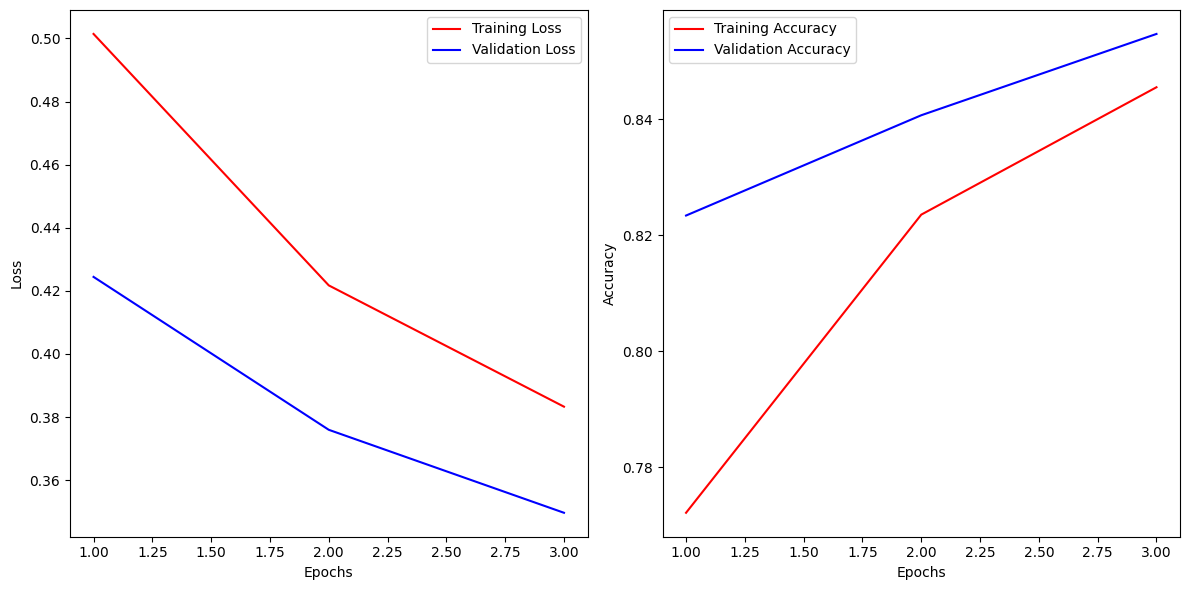

535/535 [==============================] - 37s 63ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.8692 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.8878 |   0.8304 |     0.8582 |
+---------+-------------+----------+------------+
| Class 1 |      0.8541 |   0.9045 |     0.8786 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type     |   Precision |   Recall |   F1-score |
+==================+=============+==========+============+
| Macro average    |      0.871  |   0.8674 |     0.8684 |
+------------------+-------------+----------+------------+
| Micro average    |      0.8692 |   0.8692 |     0.8692 |
+------------------+-------------+----------+------------+
| Weighted average |      0.8702 |   0.8692 |     0.8688 |
+-----

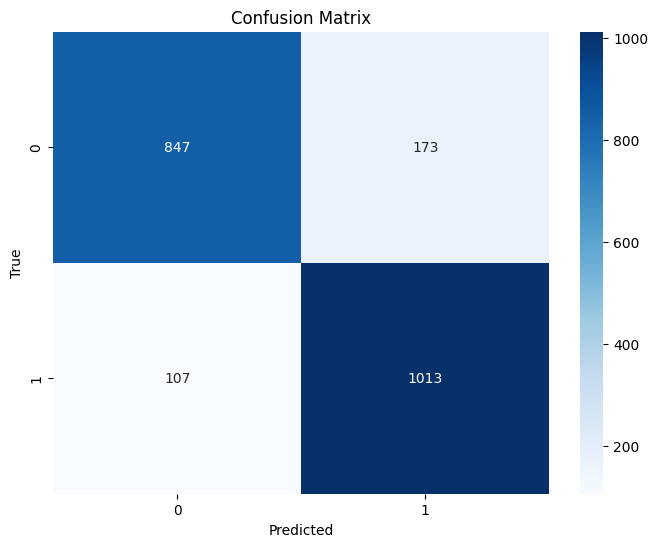

In [ ]:
history = model.fit(train_dataset, epochs=3, validation_data=valid_dataset)

training_metrics(history)

y_pred = model.predict(Xtest)
y_pred = (y_pred >= 0.5).astype(int)
test_metrics(test['label'], y_pred, num_classes=2)

### 2. BERT + BiGRU

In [ ]:
model = create_model(bert_model, fine_tune = False, gru = True)
show_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
train_dataset, valid_dataset, Xtest = create_datasets(bert_tokenizer, batch_size = 4)

Epoch 1/3
1605/1605 [==============================] - 181s 103ms/step - loss: 0.2065 - accuracy: 0.9151 - val_loss: 0.1285 - val_accuracy: 0.9505
Epoch 2/3
1605/1605 [==============================] - 163s 102ms/step - loss: 0.1190 - accuracy: 0.9539 - val_loss: 0.0978 - val_accuracy: 0.9636
Epoch 3/3
1605/1605 [==============================] - 165s 103ms/step - loss: 0.0729 - accuracy: 0.9763 - val_loss: 0.0918 - val_accuracy: 0.9673


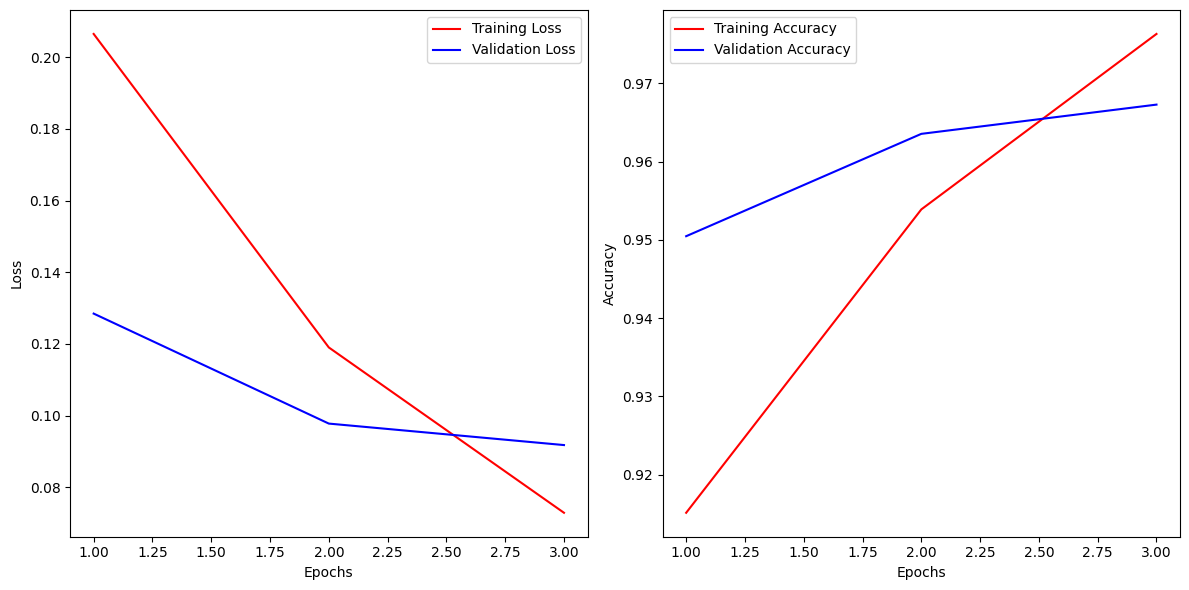

535/535 [==============================] - 39s 66ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.9589 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.9489 |   0.9657 |     0.9572 |
+---------+-------------+----------+------------+
| Class 1 |      0.9682 |   0.9527 |     0.9604 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type     |   Precision |   Recall |   F1-score |
+==================+=============+==========+============+
| Macro average    |      0.9586 |   0.9592 |     0.9588 |
+------------------+-------------+----------+------------+
| Micro average    |      0.9589 |   0.9589 |     0.9589 |
+------------------+-------------+----------+------------+
| Weighted average |      0.959  |   0.9589 |     0.9589 |
+-----

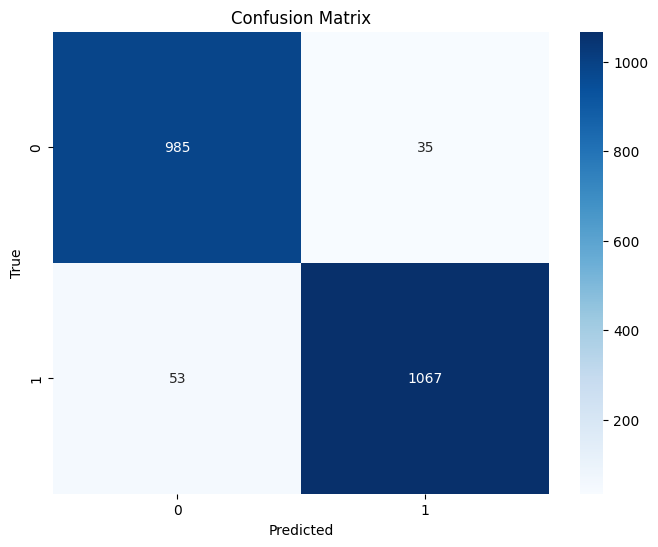

In [ ]:
history = model.fit(train_dataset, epochs=3, validation_data=valid_dataset)

training_metrics(history)

y_pred = model.predict(Xtest)
y_pred = (y_pred >= 0.5).astype(int)
test_metrics(test['label'], y_pred, num_classes=2)

### 3. CT-BERT + BiGRU

In [ ]:
model = create_model(CTbert_model, fine_tune = False, gru = True)
show_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
train_dataset, valid_dataset, Xtest = create_datasets(CTbert_tokenizer, batch_size = 4)

Epoch 1/3
1605/1605 [==============================] - 402s 234ms/step - loss: 0.1436 - accuracy: 0.9421 - val_loss: 0.0959 - val_accuracy: 0.9659
Epoch 2/3
1605/1605 [==============================] - 368s 229ms/step - loss: 0.0614 - accuracy: 0.9774 - val_loss: 0.0872 - val_accuracy: 0.9659
Epoch 3/3
1605/1605 [==============================] - 368s 229ms/step - loss: 0.0326 - accuracy: 0.9889 - val_loss: 0.0841 - val_accuracy: 0.9682


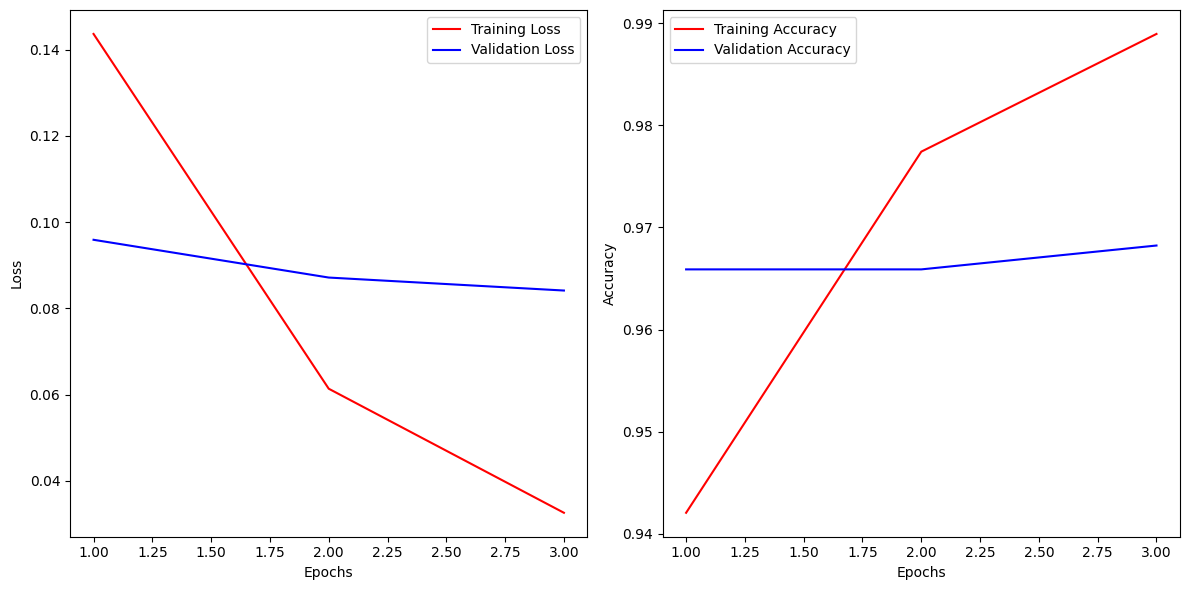

535/535 [==============================] - 89s 152ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.9701 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.9742 |   0.9627 |     0.9684 |
+---------+-------------+----------+------------+
| Class 1 |      0.9664 |   0.9768 |     0.9716 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type     |   Precision |   Recall |   F1-score |
+==================+=============+==========+============+
| Macro average    |      0.9703 |   0.9698 |     0.97   |
+------------------+-------------+----------+------------+
| Micro average    |      0.9701 |   0.9701 |     0.9701 |
+------------------+-------------+----------+------------+
| Weighted average |      0.9701 |   0.9701 |     0.9701 |
+----

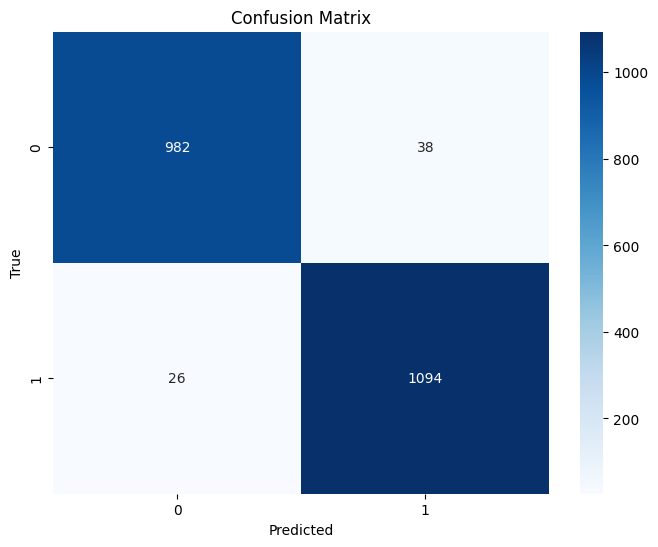

In [ ]:
history = model.fit(train_dataset, epochs=3, validation_data=valid_dataset)

training_metrics(history)

y_pred = model.predict(Xtest)
y_pred = (y_pred >= 0.5).astype(int)
test_metrics(test['label'], y_pred, num_classes=2)

## Fine Tune

### 1. BERT

In [ ]:
model = create_model(bert_model, fine_tune = True, gru = False)
show_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
train_dataset, valid_dataset, Xtest = create_datasets(bert_tokenizer, batch_size = 4)

Epoch 1/3
1605/1605 [==============================] - 329s 165ms/step - loss: 0.2101 - accuracy: 0.9139 - val_loss: 0.1275 - val_accuracy: 0.9509
Epoch 2/3
1605/1605 [==============================] - 253s 158ms/step - loss: 0.0873 - accuracy: 0.9715 - val_loss: 0.1253 - val_accuracy: 0.9654
Epoch 3/3
1605/1605 [==============================] - 248s 155ms/step - loss: 0.0885 - accuracy: 0.9749 - val_loss: 0.1093 - val_accuracy: 0.9607


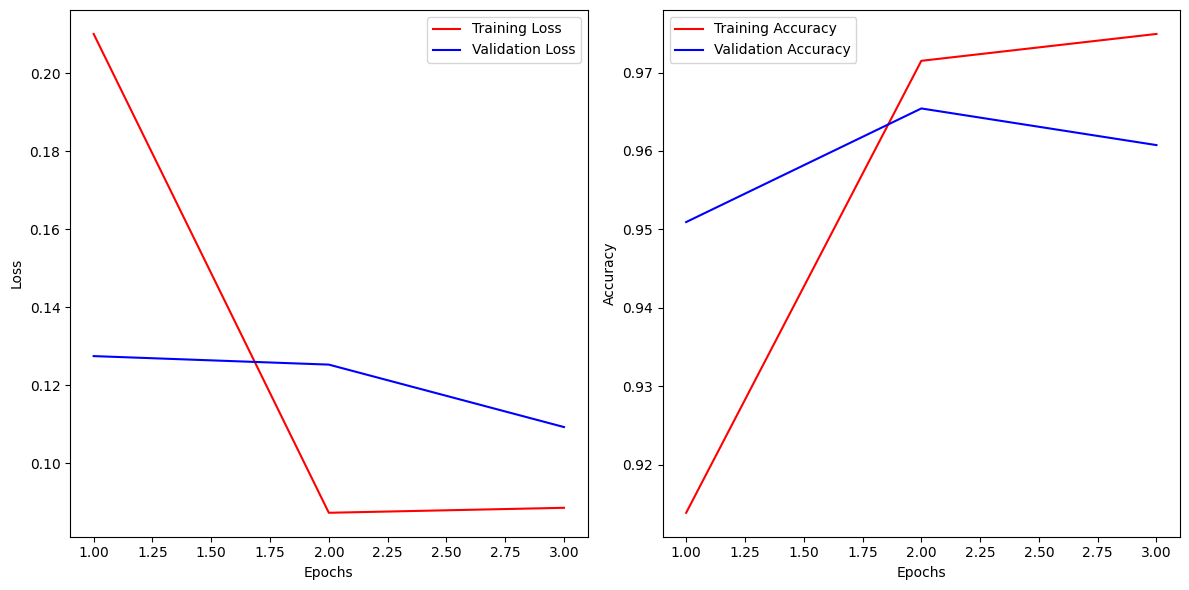

535/535 [==============================] - 28s 47ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.9589 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.9726 |   0.9402 |     0.9561 |
+---------+-------------+----------+------------+
| Class 1 |      0.9471 |   0.9759 |     0.9613 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type     |   Precision |   Recall |   F1-score |
+==================+=============+==========+============+
| Macro average    |      0.9599 |   0.958  |     0.9587 |
+------------------+-------------+----------+------------+
| Micro average    |      0.9589 |   0.9589 |     0.9589 |
+------------------+-------------+----------+------------+
| Weighted average |      0.9593 |   0.9589 |     0.9588 |
+-----

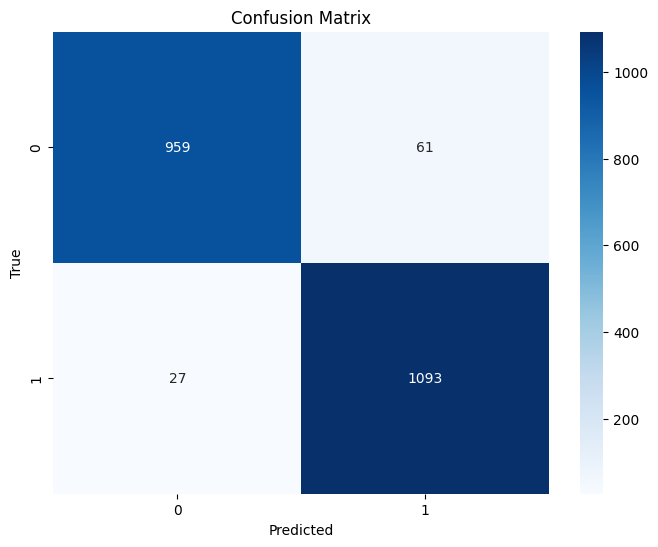

In [ ]:
history = model.fit(train_dataset, epochs=3, validation_data=valid_dataset)

training_metrics(history)

y_pred = model.predict(Xtest)
y_pred = (y_pred >= 0.5).astype(int)
test_metrics(test['label'], y_pred, num_classes=2)

### 2. BERT + BiGRU

In [21]:
model = create_model(bert_model, fine_tune = True, gru = True)
show_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
train_dataset, valid_dataset, Xtest = create_datasets(bert_tokenizer, batch_size = 4)

Epoch 1/3


1605/1605 [==============================] - 331s 173ms/step - loss: 0.1607 - accuracy: 0.9368 - val_loss: 0.0960 - val_accuracy: 0.9612
Epoch 2/3
1605/1605 [==============================] - 267s 166ms/step - loss: 0.0475 - accuracy: 0.9850 - val_loss: 0.0646 - val_accuracy: 0.9724
Epoch 3/3
1605/1605 [==============================] - 266s 166ms/step - loss: 0.0167 - accuracy: 0.9947 - val_loss: 0.0802 - val_accuracy: 0.9748


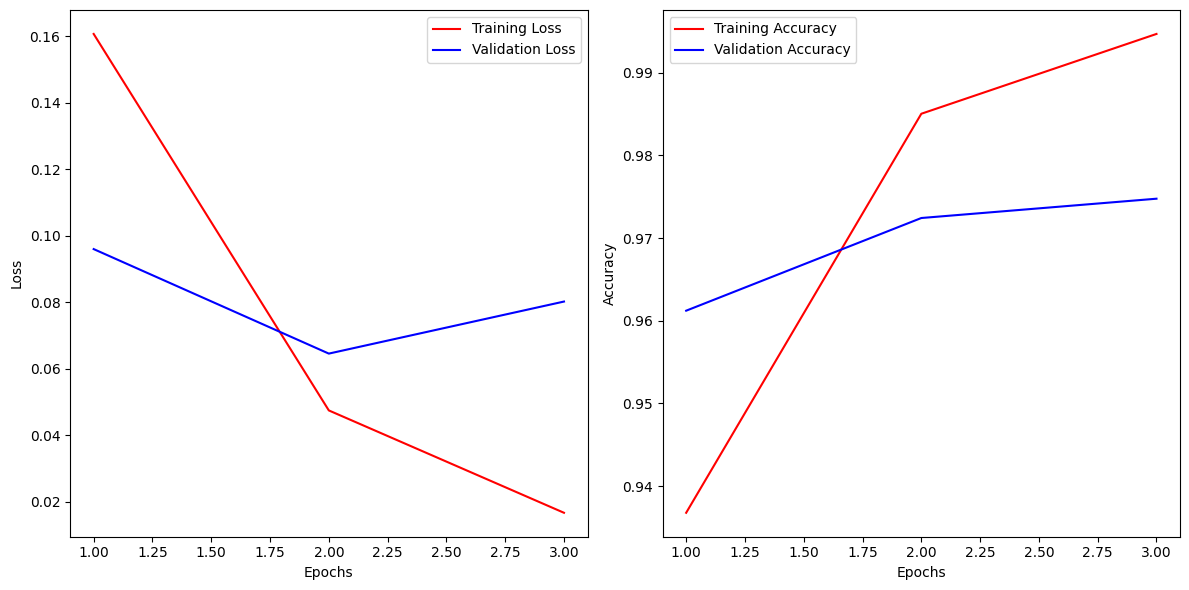

535/535 [==============================] - 32s 51ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.9734 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.9753 |   0.9686 |     0.972  |
+---------+-------------+----------+------------+
| Class 1 |      0.9716 |   0.9777 |     0.9746 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type     |   Precision |   Recall |   F1-score |
+==================+=============+==========+============+
| Macro average    |      0.9735 |   0.9732 |     0.9733 |
+------------------+-------------+----------+------------+
| Micro average    |      0.9734 |   0.9734 |     0.9734 |
+------------------+-------------+----------+------------+
| Weighted average |      0.9734 |   0.9734 |     0.9734 |
+-----

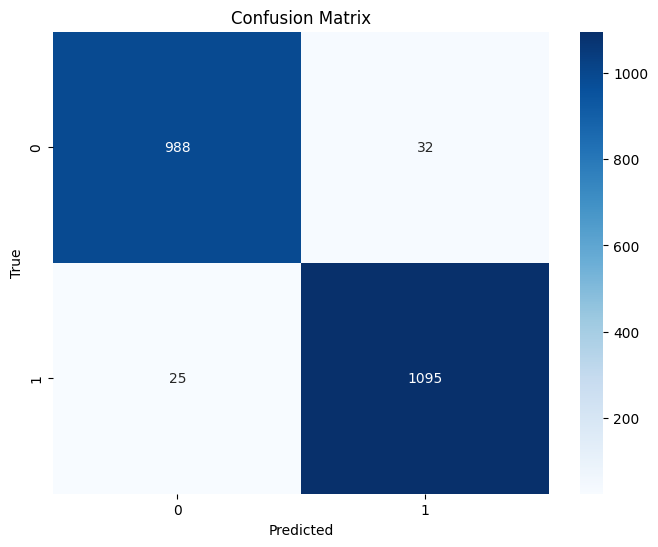

In [24]:
history = model.fit(train_dataset, epochs=3, validation_data=valid_dataset)

training_metrics(history)

y_pred = model.predict(Xtest)
y_pred = (y_pred >= 0.5).astype(int)
test_metrics(test['label'], y_pred, num_classes=2)

### 3. CT-BERT + BiGRU

In [26]:
model = create_model(CTbert_model, fine_tune = True, gru = True)
show_model(model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   3351418   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   88         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 1                                     

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
train_dataset, valid_dataset, Xtest = create_datasets(CTbert_tokenizer, batch_size = 4)

Epoch 1/3


1605/1605 [==============================] - 865s 479ms/step - loss: 0.1222 - accuracy: 0.9531 - val_loss: 0.0713 - val_accuracy: 0.9748
Epoch 2/3
1605/1605 [==============================] - 757s 472ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 0.0605 - val_accuracy: 0.9794
Epoch 3/3
1605/1605 [==============================] - 757s 472ms/step - loss: 0.0157 - accuracy: 0.9953 - val_loss: 0.0680 - val_accuracy: 0.9799


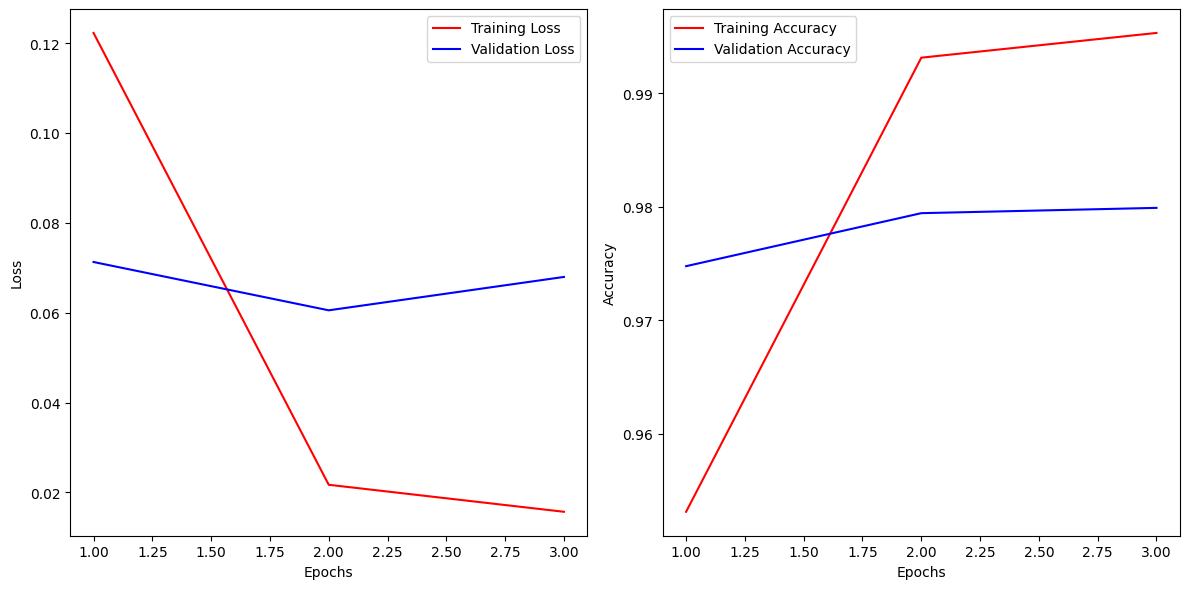

535/535 [==============================] - 81s 138ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |   0.978 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.9831 |   0.9706 |     0.9768 |
+---------+-------------+----------+------------+
| Class 1 |      0.9735 |   0.9848 |     0.9791 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type     |   Precision |   Recall |   F1-score |
+==================+=============+==========+============+
| Macro average    |      0.9783 |   0.9777 |      0.978 |
+------------------+-------------+----------+------------+
| Micro average    |      0.978  |   0.978  |      0.978 |
+------------------+-------------+----------+------------+
| Weighted average |      0.9781 |   0.978  |      0.978 |
+----

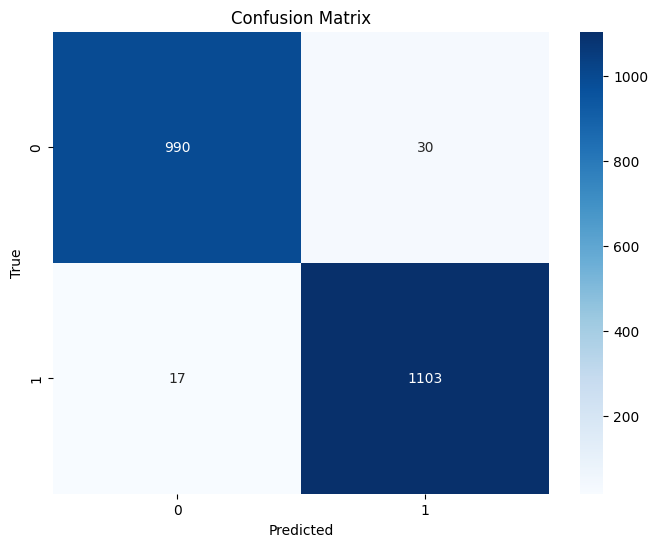

In [29]:
history = model.fit(train_dataset, epochs=3, validation_data=valid_dataset)

training_metrics(history)

y_pred = model.predict(Xtest)
y_pred = (y_pred >= 0.5).astype(int)
test_metrics(test['label'], y_pred, num_classes=2)